# Assignment 3 - LLM coding and report submission

**DATASET USED:** IMDB DATASET<br><br>
**System USED:** GOOGLE COLAB <br><br>
**GPU:** Tesla T4 GPU<br><br>
**Goals of Project:**<br>
<p>In this project, I am aiming to predict the sentiment of Imdb reviews as either positive or negative. The maximum length of words per review is limited to 256 words for faster training. </p>

#Installing modules
importing datasets from hugging face

In [1]:
!pip install transformers datasets torch numpy pandas tqdm wandb scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import wandb
from tqdm.auto import tqdm

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Model: Tesla T4


## Load Dataset from Hugging Face

In [3]:
print("Loading IMDB dataset...")
dataset = load_dataset("imdb")


Loading IMDB dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Checking Dataset

In [14]:
train_df = pd.DataFrame({
    'text': dataset['train']['text'],
    'label': dataset['train']['label']
})

test_df = pd.DataFrame({
    'text': dataset['test']['text'],
    'label': dataset['test']['label']
})

In [15]:
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nSample from training set:")
print(train_df.head(2))

# Check class distribution
print("\nClass distribution in training set:")
print(train_df['label'].value_counts())

Training set shape: (25000, 2)
Test set shape: (25000, 2)

Sample from training set:
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0

Class distribution in training set:
label
0    12500
1    12500
Name: count, dtype: int64


Checking a sample review

In [17]:
print("\nDataset Info:")
print(train_df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [16]:
print("Sample review:")
print("-" * 50)
print(dataset['train'][0]['text'][:500])
print("-" * 50)
print("Label:", "Positive" if dataset['train'][0]['label'] == 1 else "Negative")


Sample review:
--------------------------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent
--------------------------------------------------
Label: Negative


###Step 3: Fine-tuning masked language models

Tokenize training testing dataset

In [4]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors=None
    )
tokenized_train = dataset["train"].map(tokenize_function, batched=True)
tokenized_test = dataset["test"].map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [5]:
#making pytorch tensors
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


In [6]:
#Aiming for faster training so using increased batch size

train_dataloader = DataLoader(
    tokenized_train,
    shuffle=True,
    batch_size=16
)
test_dataloader = DataLoader(
    tokenized_test,
    batch_size=16
)


## Word cloud




 POSITIVE REVIEWS TEST DATASET


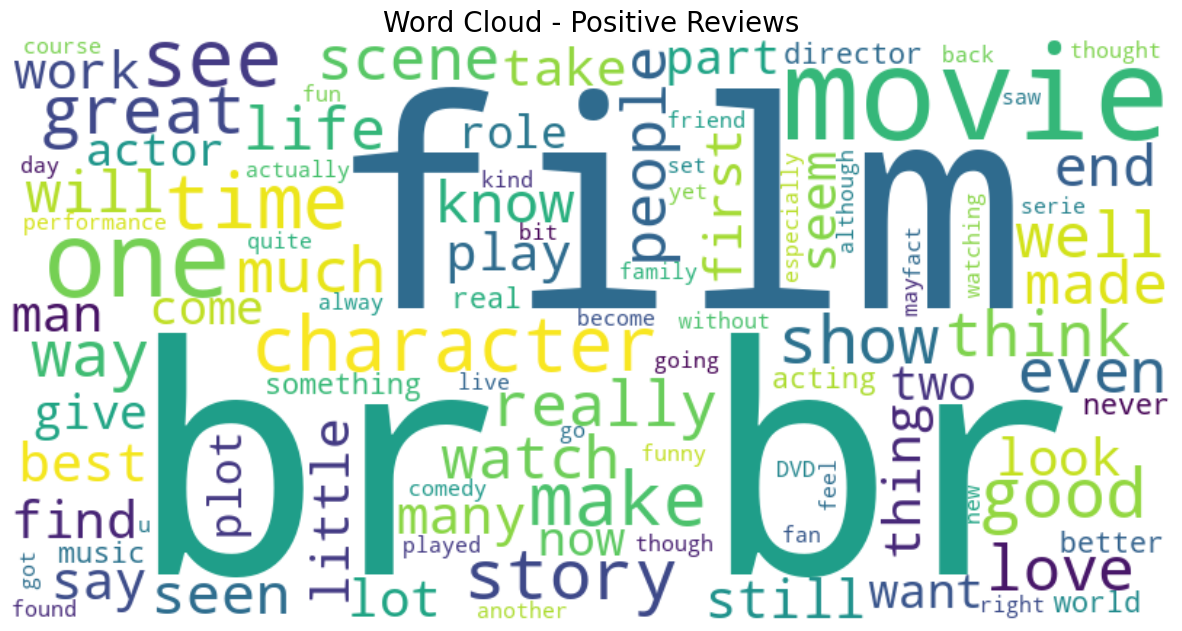



 Negative REVIEWS TEST DATASET


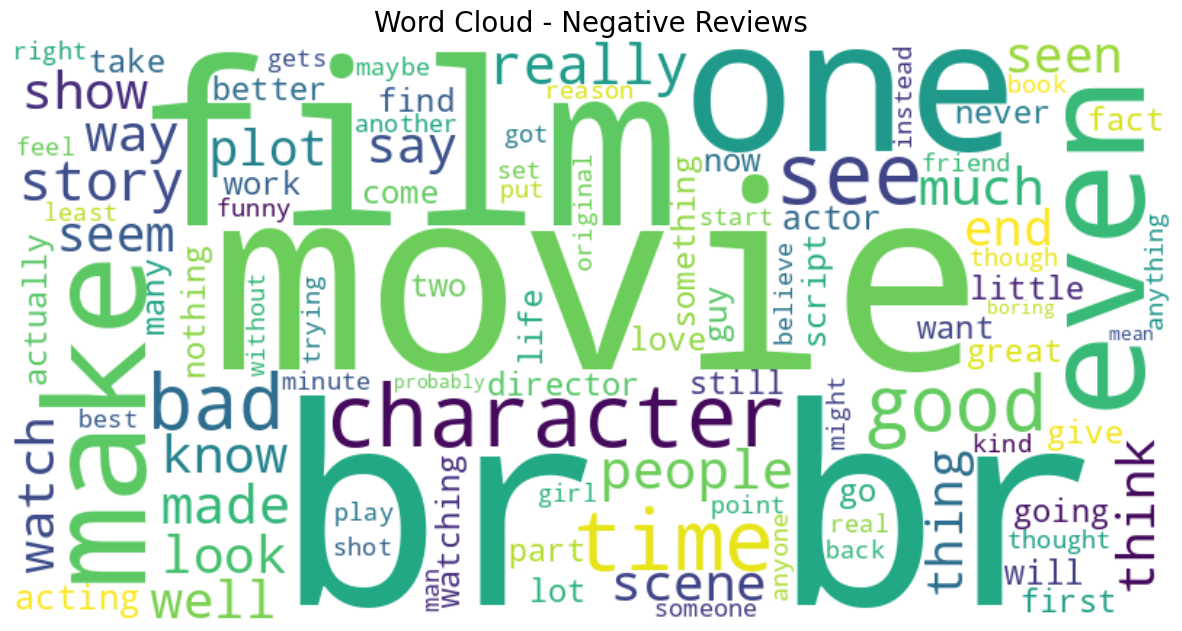

In [23]:
def create_wordcloud(texts, labels, sentiment="positive"):
    """Create wordcloud for positive/negative reviews"""
    # Combine texts based on sentiment
    combined_text = " ".join([text for text, label in zip(texts, labels)
                            if label == (1 if sentiment == "positive" else 0)])

    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(combined_text)

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    plt.title(f'Word Cloud - {sentiment.title()} Reviews',fontsize=20)
    plt.show()

#For test set
print("\n\n POSITIVE REVIEWS TEST DATASET")
create_wordcloud(dataset["test"]["text"], dataset["test"]["label"], "positive")

print("\n\n Negative REVIEWS TEST DATASET")
create_wordcloud(dataset["test"]["text"], dataset["test"]["label"], "negative")





 POSITIVE REVIEWS TRAIN DATASET


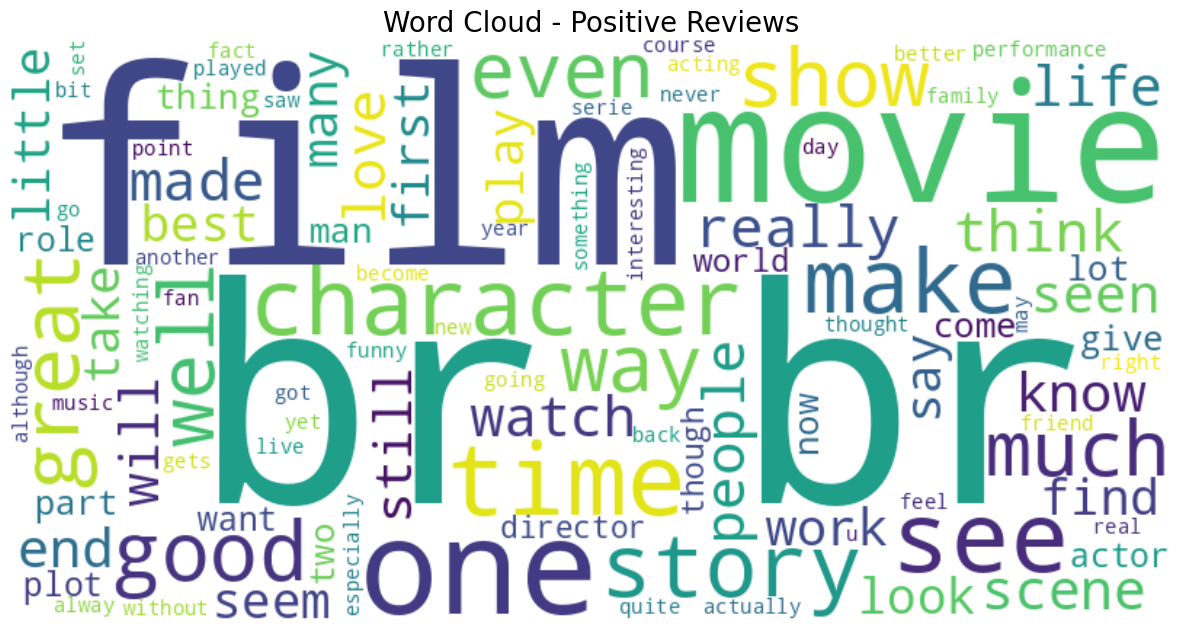



 Negative REVIEWS TRAIN DATASET


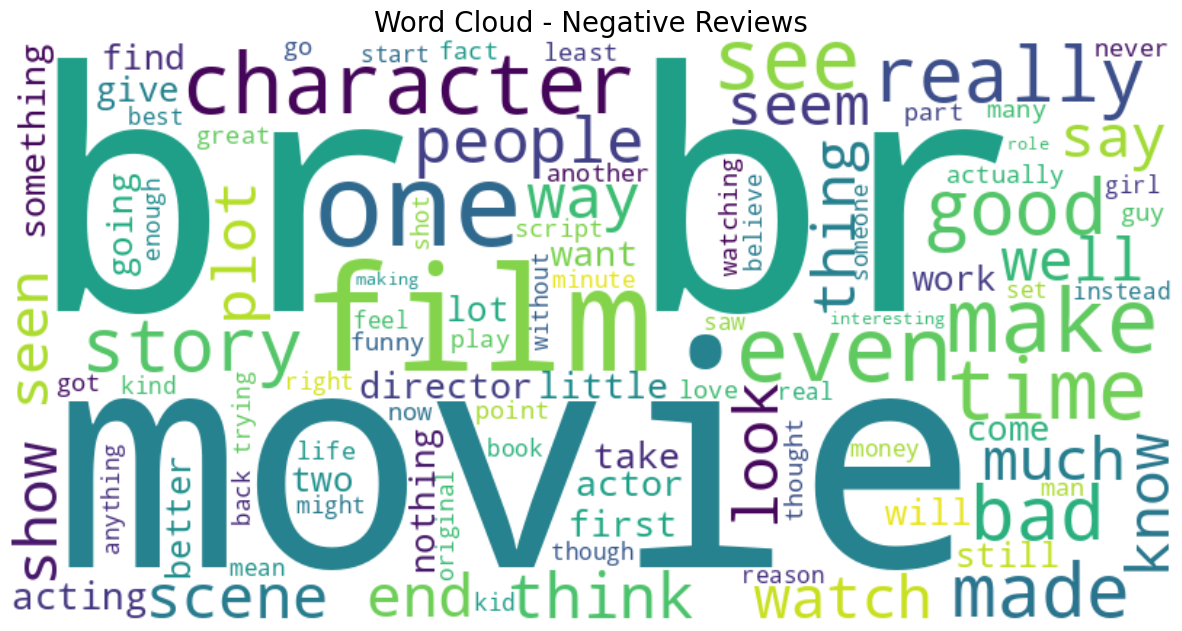

In [24]:
#For train dataset
print("\n\n POSITIVE REVIEWS TRAIN DATASET")
create_wordcloud(dataset["train"]["text"], dataset["train"]["label"], "positive")

print("\n\n Negative REVIEWS TRAIN DATASET")
create_wordcloud(dataset["train"]["text"], dataset["train"]["label"], "negative")

# Step4: Model Fine tuning Setup



Using Bert Base uncased model for the sentiment analysis dataset

In [7]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    hidden_dropout_prob=0.2, # setting parameters
    attention_probs_dropout_prob=0.2
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###MODEL Architecture

In [8]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Adam Optimizer

Learning Rate: 0.00002
<br>
weight_decay=0.01

In [9]:
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    weight_decay=0.01
)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


###Learning rate scheduler

In [34]:
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
print("Number of training steps: ", num_training_steps)
num_warmup_steps = num_training_steps // 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

Number of training steps:  4689


###Training Function

In [11]:
def train_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update weights
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

###Evaluation Function

In [12]:
def evaluate(model, dataloader):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            predictions.extend(outputs.logits.argmax(-1).cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        actual_labels,
        predictions,
        average='binary'
    )
    accuracy = accuracy_score(actual_labels, predictions)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# TRAINING AND FIND BEST FIT

Checking for best f1 to find best model

In [13]:
print("Starting training...")
best_f1 = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training
    avg_train_loss = train_epoch(model, train_dataloader, optimizer, scheduler)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Evaluation
    eval_metrics = evaluate(model, test_dataloader)
    print("\nEvaluation metrics:")
    for metric, value in eval_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Save best model
    if eval_metrics["f1"] > best_f1:
        best_f1 = eval_metrics["f1"]
        model.save_pretrained("./best_model")
        tokenizer.save_pretrained("./best_model")

Starting training...

Epoch 1/3


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Average training loss: 0.3460


Evaluating:   0%|          | 0/1563 [00:00<?, ?it/s]


Evaluation metrics:
accuracy: 0.9110
precision: 0.8872
recall: 0.9418
f1: 0.9137

Epoch 2/3


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Average training loss: 0.2123


Evaluating:   0%|          | 0/1563 [00:00<?, ?it/s]


Evaluation metrics:
accuracy: 0.9148
precision: 0.8836
recall: 0.9555
f1: 0.9182

Epoch 3/3


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Average training loss: 0.1539


Evaluating:   0%|          | 0/1563 [00:00<?, ?it/s]


Evaluation metrics:
accuracy: 0.9228
precision: 0.9146
recall: 0.9328
f1: 0.9236


In [25]:
def test_model(text):
    # Tokenize input
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    # Get prediction
    outputs = model(**inputs)
    prediction = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = prediction.cpu().detach().numpy()

    # Return result
    sentiment = "Positive" if prediction[0][1] > prediction[0][0] else "Negative"
    confidence = prediction[0][1] if sentiment == "Positive" else prediction[0][0]

    return {
        "sentiment": sentiment,
        "confidence": float(confidence)
    }

# Test cases
test_texts = [
    "This movie was absolutely fantastic! A masterpiece!",
    "Terrible waste of time. Don't watch this movie.",
    "It's not great, but not terrible either. Somewhat entertaining.",
]

print("\nTesting model with example texts:")
for text in test_texts:
    result = test_model(text)
    print(f"\nText: {text}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']:.4f}")


Testing model with example texts:

Text: This movie was absolutely fantastic! A masterpiece!
Sentiment: Positive
Confidence: 0.9982

Text: Terrible waste of time. Don't watch this movie.
Sentiment: Negative
Confidence: 0.9978

Text: It's not great, but not terrible either. Somewhat entertaining.
Sentiment: Negative
Confidence: 0.9934


#VISUALIZING PERFORMANCE

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Store training metrics
class MetricTracker:
    def __init__(self):
        self.train_losses = []
        self.eval_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    def update_train_loss(self, loss):
        self.train_losses.append(loss)

    def update_eval_metrics(self, metrics):
        for k, v in metrics.items():
            self.eval_metrics[k].append(v)

metric_tracker = MetricTracker()


metric_tracker.update_train_loss(0.3460)  # Epoch 1
metric_tracker.update_train_loss(0.2123)  # Epoch 2
metric_tracker.update_train_loss(0.1539)  # Epoch 3


# Epoch 1
metric_tracker.update_eval_metrics({
    'accuracy': 0.9110,
    'precision': 0.8872,
    'recall': 0.9418,
    'f1': 0.9137
})

# Epoch 2
metric_tracker.update_eval_metrics({
    'accuracy': 0.9148,
    'precision': 0.8836,
    'recall': 0.9555,
    'f1': 0.9182
})

# Epoch 3
metric_tracker.update_eval_metrics({
    'accuracy': 0.9228,
    'precision': 0.9146,
    'recall': 0.9328,
    'f1': 0.9236
})

## TRAINING LOSS PLOT

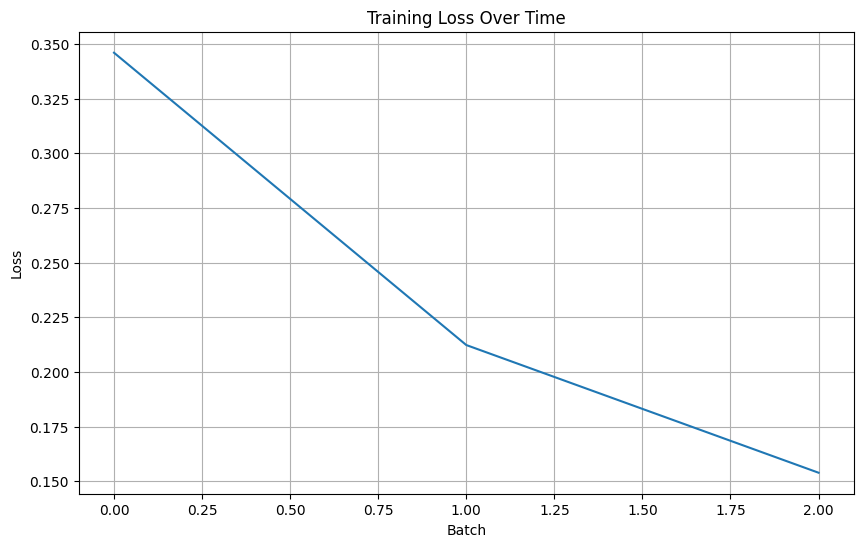

In [27]:

plt.figure(figsize=(10, 6))
plt.plot(metric_tracker.train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



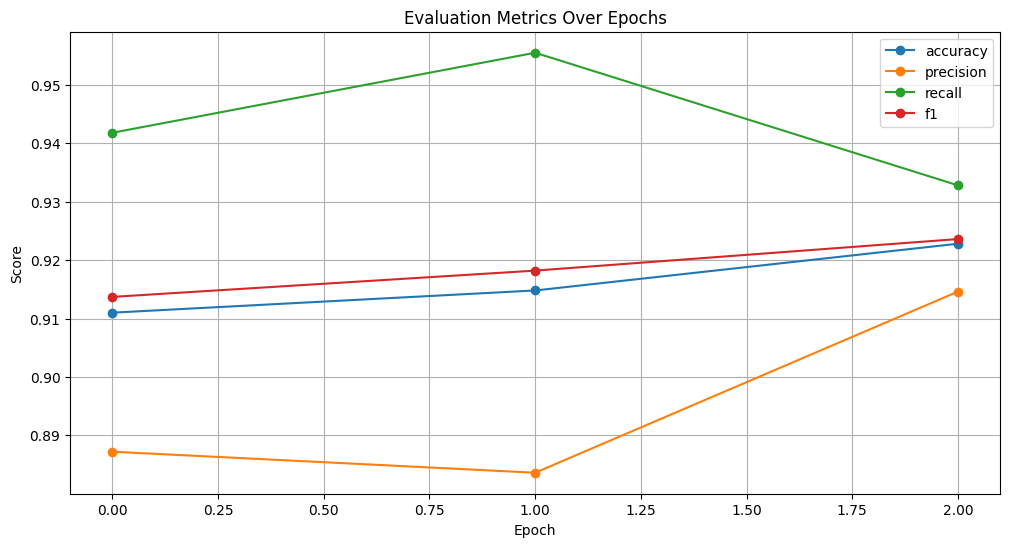

In [28]:
#Evaluation Plot

plt.figure(figsize=(12, 6))
for metric, values in metric_tracker.eval_metrics.items():
    plt.plot(values, label=metric, marker='o')
plt.title('Evaluation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
def get_predictions():
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    return y_true, y_pred

y_true, y_pred = get_predictions()

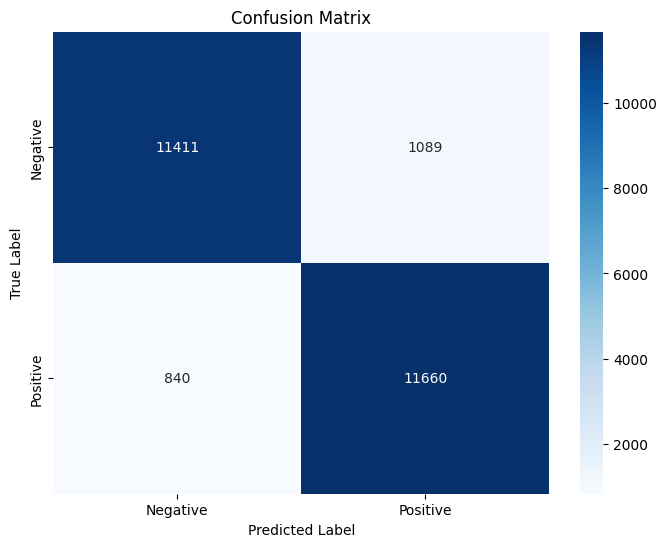

In [37]:
#Confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_true,y_pred)

Prediction Distribution

Getting predictions: 100%|██████████| 1563/1563 [05:24<00:00,  4.82it/s]


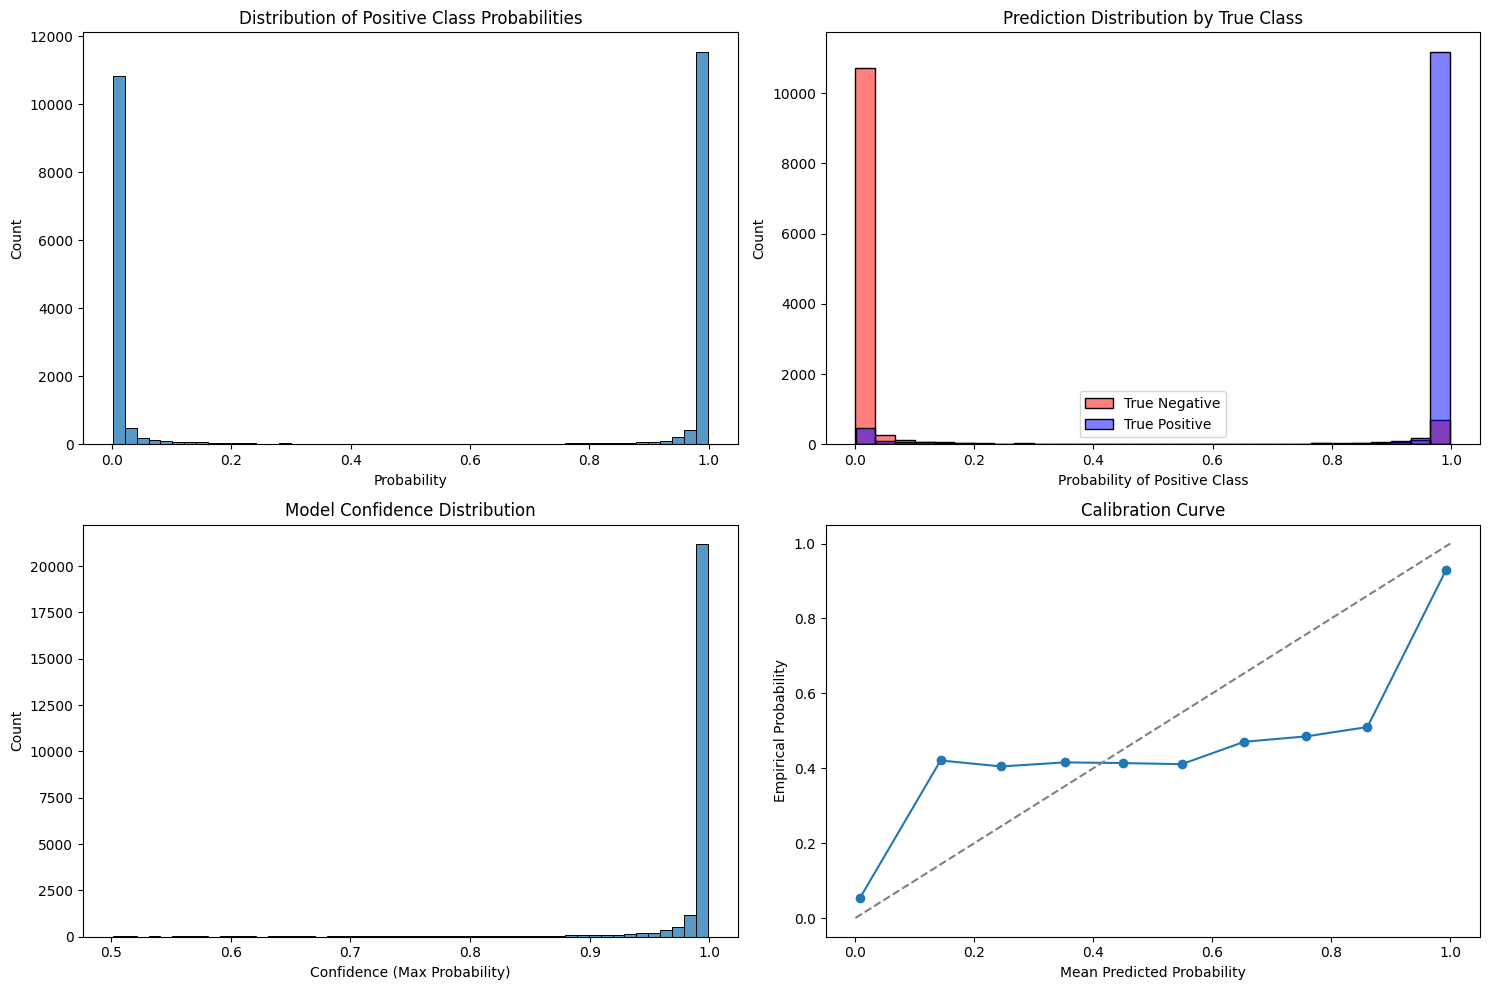


Prediction Distribution Summary:
Mean confidence: 0.984
Median confidence: 0.997
Std of confidence: 0.050
% of predictions with >90% confidence: 96.1%

Normalized Confusion Matrix:
[[0.91288 0.08712]
 [0.0672  0.9328 ]]


In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def get_prediction_distributions(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Get probability distributions using softmax
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_predictions.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

# Get predictions
predictions, labels = get_prediction_distributions(model, test_dataloader, device)

# Create figure with multiple subplots
plt.figure(figsize=(15, 10))

# 1. Overall Distribution of Prediction Probabilities
plt.subplot(2, 2, 1)
sns.histplot(predictions[:, 1], bins=50)
plt.title('Distribution of Positive Class Probabilities')
plt.xlabel('Probability')
plt.ylabel('Count')

# 2. Separate distributions for each true class
plt.subplot(2, 2, 2)
sns.histplot(predictions[labels == 0][:, 1], bins=30, color='red', alpha=0.5, label='True Negative')
sns.histplot(predictions[labels == 1][:, 1], bins=30, color='blue', alpha=0.5, label='True Positive')
plt.title('Prediction Distribution by True Class')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Count')
plt.legend()

# 3. Confidence Distribution
confidence_scores = np.max(predictions, axis=1)
plt.subplot(2, 2, 3)
sns.histplot(confidence_scores, bins=50)
plt.title('Model Confidence Distribution')
plt.xlabel('Confidence (Max Probability)')
plt.ylabel('Count')

# 4. Calibration Curve (Reliability Diagram)
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(labels, predictions[:, 1], n_bins=10)
plt.subplot(2, 2, 4)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Empirical Probability')

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nPrediction Distribution Summary:")
print(f"Mean confidence: {confidence_scores.mean():.3f}")
print(f"Median confidence: {np.median(confidence_scores):.3f}")
print(f"Std of confidence: {confidence_scores.std():.3f}")
print(f"% of predictions with >90% confidence: {(confidence_scores > 0.9).mean()*100:.1f}%")

# Calculate and print confusion matrix with probabilities
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, predictions.argmax(axis=1), normalize='true')
print("\nNormalized Confusion Matrix:")
print(cm)

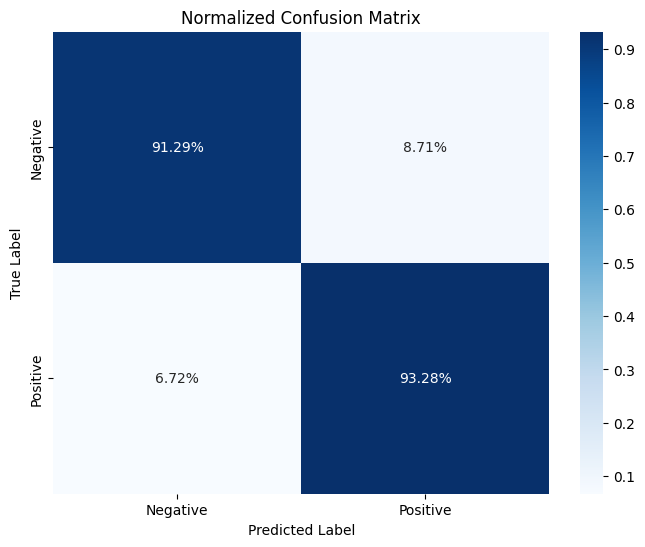

In [40]:

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='.2%',
            cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#SAVING MODEL FILE

In [35]:
print("\nSaving final model...")
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/bert_sentiment_model"
!cp -r ./final_model/* "/content/drive/MyDrive/bert_sentiment_model/"


Saving final model...
Mounted at /content/drive


#CONCLUSION